In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pylab as pl
%matplotlib inline

pl.style.use('latexplot')

In [2]:
# Data from the peng paper
data = np.loadtxt('peng.txt', delimiter=',')

In [3]:
# Picking the data before re-injection of solute:
t_data = data.T[0][:11]
r_data = data.T[1][:11]
# Generating the fitted curve from data by interpolation:
r_fit = interp1d(t_data, r_data, kind = 'slinear')

In [4]:
lcap = 6e-9
# Taking the value from fit at t = 0:
R0   = r_fit(0) * 1e-9
cinf = 55.33
cs   = 5.53e-2
Vm   = 3.29e-5

In [5]:
def dR_dt(R, t, beta, Da, delta_C):
    dRdt = (cinf - beta * R**3 - cs * np.exp(lcap / (R0 * R)))/(delta_C * (Da + R))
    return dRdt

In [6]:
def compute_residual(x):
    D  = x[0]
    k  = x[1]
    cs = x[2]
    N0 = x[3]
    
    beta    = 4 * np.pi * N0 * R0**3 / (3 * Vm)
    Da      = D/(k*R0)
    delta_C = cinf - cs * np.exp(lcap/R0)
    t0      = R0**2 / (Vm * D * delta_C)
    
    t   = t_data[3:11]
    sol = odeint(dR_dt, 1, 60 * t / t0, args = (beta, Da, delta_C), rtol = 1e-12)

    return(np.mean(abs(sol.ravel() * R0 / 1e-9 - r_fit(t))))

In [7]:
def fit_parameters_curvefit(t, D, k, cs, N0):
    # Roughly guiding the algorithm:
    D  = D  * 1e-18
    k  = k  * 1e-10
    cs = cs * 1e-2
    N0 = N0 * 1e21
    
    beta    = 4 * np.pi * N0 * R0**3 / (3 * Vm)
    Da      = D/(k*R0)
    delta_C = cinf - cs * np.exp(lcap/R0)
    t0      = R0**2 / (Vm * D * delta_C)
    
    sol = odeint(dR_dt, 1, 60 * t / t0, args = (beta, Da, delta_C), rtol = 1e-12)
    return(sol.ravel() * R0 / 1e-9)

In [8]:
t          = t_data[3:11] 
popt, pcov = curve_fit(fit_parameters_curvefit, t, r_fit(t), bounds = (1, 10), method = 'trf')

In [9]:
# Recovering the parameters from the curve fitting:
D, k, cs, N0 = popt * np.array([1e-18, 1e-10, 1e-2, 1e21])

In [11]:
# Checking residual:
# Parameters prescribed by Fanelli et al:
print('Residual(Fanelli et al.):', compute_residual(np.array([3.01e-18, 7.97e-10, 5.53e-2, 8.04e21])))
# Parameters obtained by us:
print('Residual(Our Fit)       :', compute_residual(popt * np.array([1e-18, 1e-10, 1e-2, 1e21])))

Residual(Fanelli et al.): 0.06275896318191293
Residual(Our Fit)       : 0.06156450754024917


In [12]:
beta    = 4 * np.pi * N0 * R0**3 / (3 * Vm)
Da      = D/(k*R0)
delta_C = cinf - cs * np.exp(lcap/R0)
t0      = R0**2 / (Vm * D * delta_C)

t   = np.linspace(0, t_data[-1], 50)
sol = odeint(dR_dt, 1, 60 * t / t0, args = (beta, Da, delta_C), rtol = 1e-12)

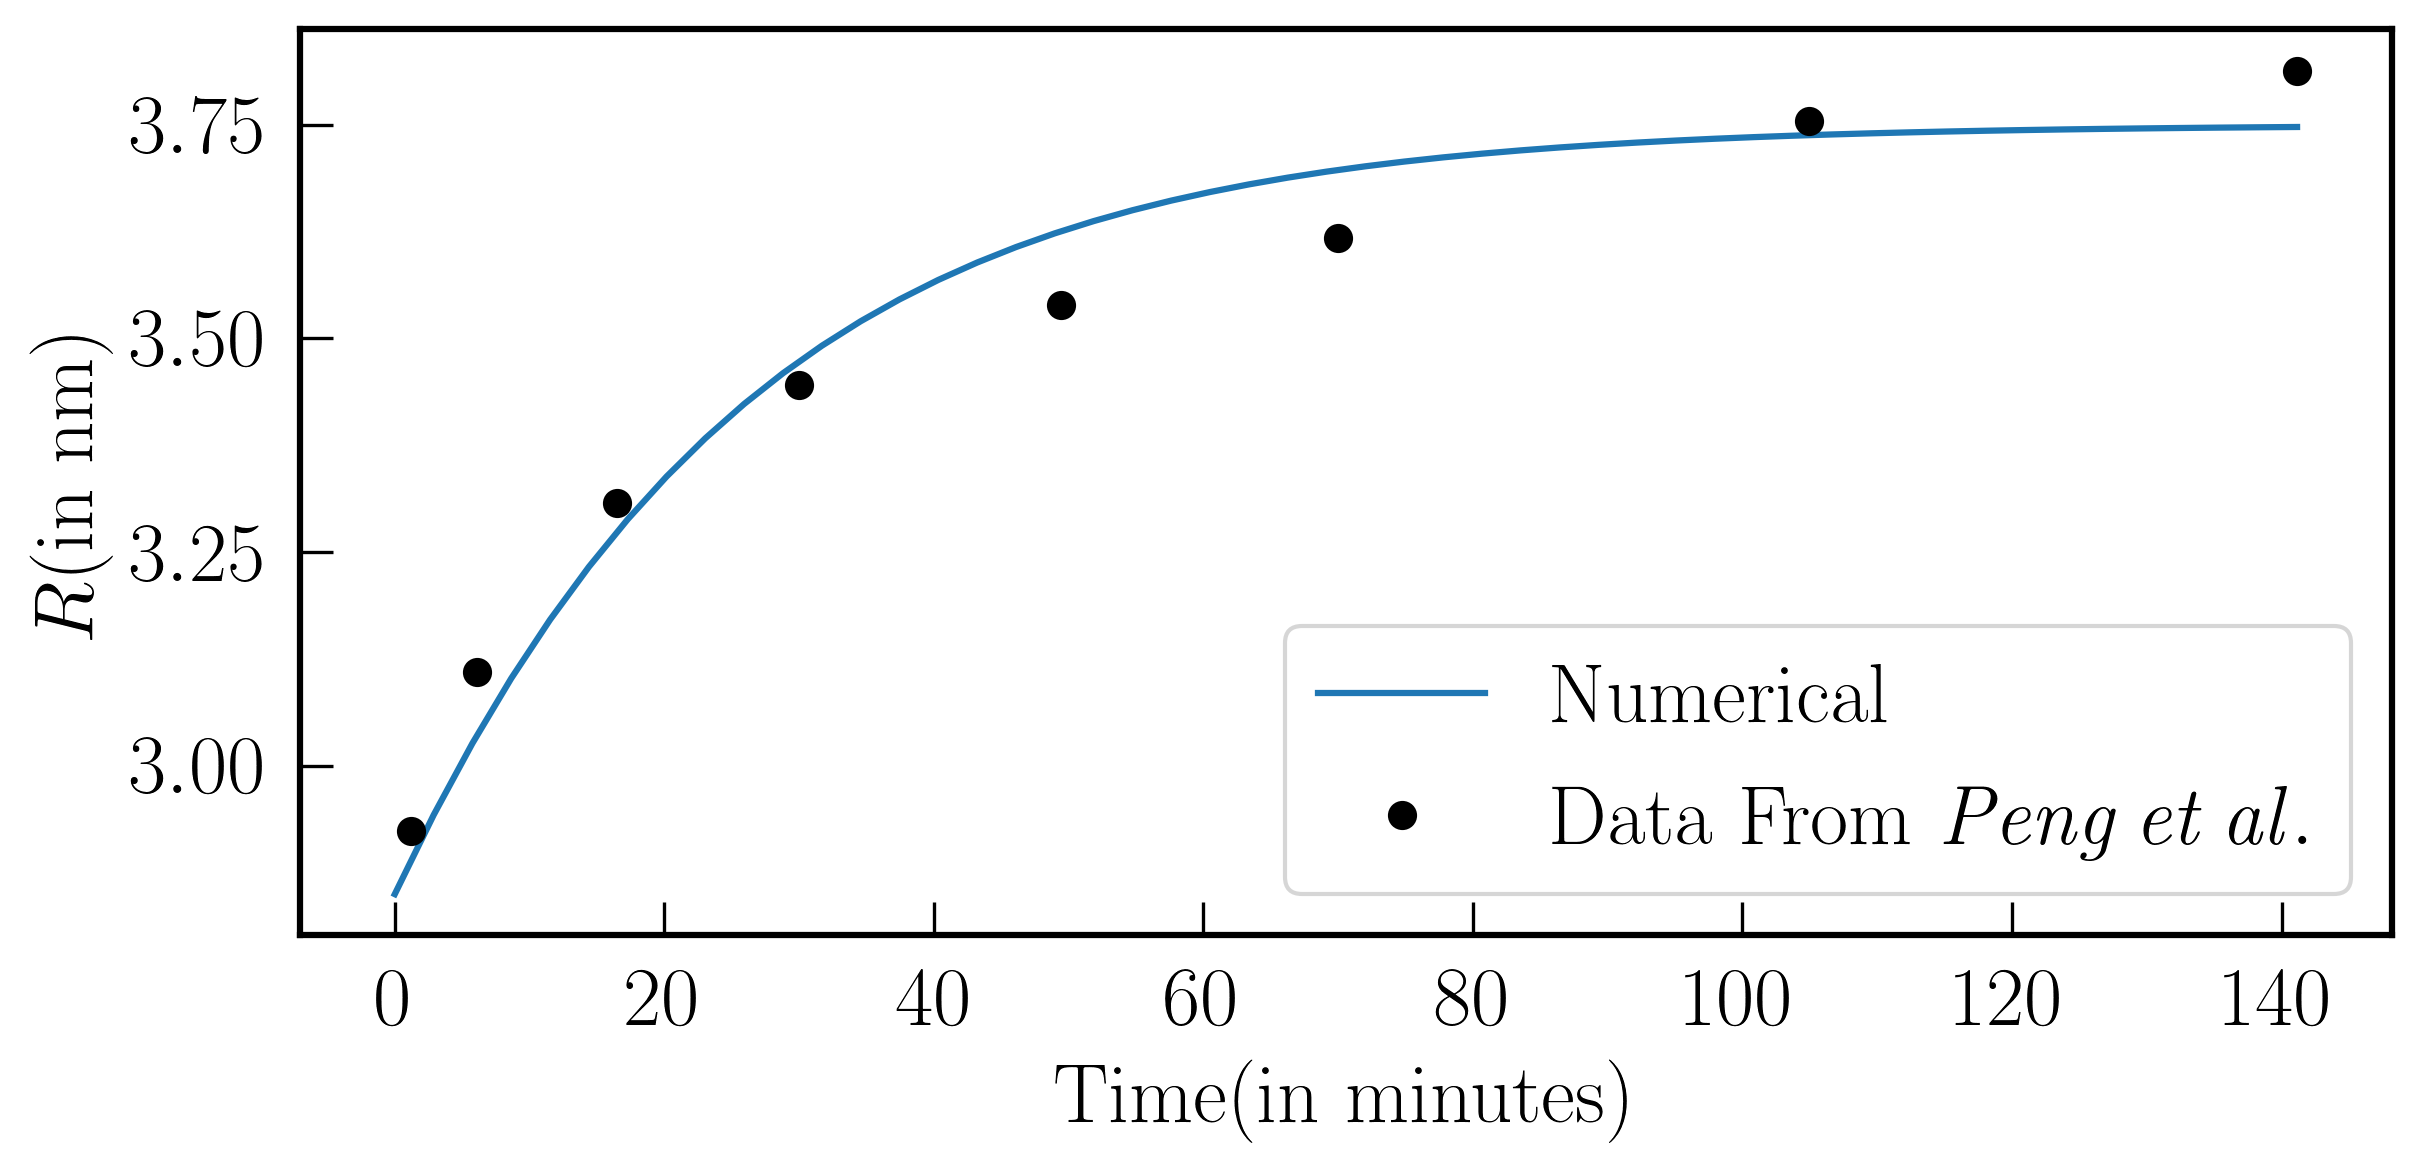

In [13]:
pl.plot(t, sol * R0 / 1e-9, label = 'Numerical')
pl.plot(t_data[3:], r_data[3:], 'ko', label = r'Data From $\it{Peng\,et\,al.}$')
pl.legend(loc = 'lower right')
pl.xlabel('Time(in minutes)')
pl.ylabel(r'$R$(in nm)')
pl.savefig('peng_fit.png', bbox_inches = 'tight', dpi = 300)

In [10]:
popt

array([ 3.49544246, 10.        ,  1.        ,  8.23390373])